# Downloads

In [1]:
#%cd /home/yandex/DLW2021/davidhay/
#!pwd
#!ls -l 

In [2]:
#!rm -rf coco
#!mkdir coco
#%cd coco

In [ ]:
#!wget -c http://images.cocodataset.org/zips/train2017.zip
#!unzip train2017.zip
#!rm train2017.zip


In [ ]:
#!wget -c http://images.cocodataset.org/zips/val2017.zip

#!unzip val2017.zip

#!rm val2017.zip


In [3]:

#!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip

#!unzip annotations_trainval2017.zip

#!rm annotations_trainval2017.zip

# Data Loading

## Imports and Vocabulary 

In [1]:

import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from PIL import Image
import pickle

spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        # PAD- padding symbol
        # SOS- Start of Sentence
        # EOS- end of sentence
        # UNK- unknown word (unknown\ below threshold)
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold
        
    def __len__(self):
      return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for index,sentence in enumerate(sentence_list):

            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    # if idx > 0 and idx % 1000==0:
                        # print(f"Added {idx} words to vocab")
                    idx += 1
            # if index>0 and index%1000==0:
                # print(f"Iterated {index} sentences")
            if len(self.stoi) >= 5000:
                break
             

        print(f"Done, added {idx-1} words to vocabulary")
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        result = [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]
        return result

## Dataset custom class

In [2]:
import pickle
class COCODataset(Dataset):
    """
    COCODataset
    """
    def __init__(self,root_dir,annotation_file,transform=None,freq_threshold=5,
                 load_vocab=False, vocab_loc = "vocab.pkl"):
      """
      can use load_vocab to use a previously created vocabulary (time saving feature)
      freq_threshold: words with a count below this number will be marked as <UNK>
      """
      self.root_dir = root_dir
      self.coco = COCO(annotation_file)
      self.transform = transform
      self.cap_max_size = 0
      #Get image and caption colum from the dataframe
      self.imgs = []
      self.captions = []
      for idx,ann in enumerate(self.coco.anns.values()):
        self.imgs.append(self.coco.loadImgs((ann['image_id']))[0]["file_name"])
        self.captions.append(ann['caption'])
        #if (idx) % 1000 == 0 and idx>0:
          #print(f"Processed {idx} images and captions")
      print("Finished processing images and captions")
      print(f"Got:{len(set(self.imgs))} pictures with {len(self.captions)} captions!")
      
      #Initialize vocabulary and build vocab
      if load_vocab:
        with open(vocab_loc, "rb") as source:
          self.vocab = pickle.load(source)
        print(f"Loaded vocabulary from {vocab_loc}")
      
      else:
        print("Build vocabulary")
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions)
        print("Finished building vocabulary")
        with open(vocab_loc, "wb") as dest:
          pickle.dump(self.vocab, dest)
      
      print(f"Using {len(self.vocab)} words")
    
    def __len__(self):
      return len(self.imgs)
    
    def __getitem__(self,idx):
      caption = self.captions[idx]
      img_name = self.imgs[idx]
      img_location = os.path.join(self.root_dir,img_name)
      img = Image.open(img_location).convert("RGB")
      
      #apply the transfromation to the image
      if self.transform:
          img = self.transform(img)
      
      #numericalize the caption text
      caption_vec = [self.vocab.stoi["<SOS>"]]
      caption_vec.extend(self.vocab.numericalize(caption))
      caption_vec.append(self.vocab.stoi["<EOS>"])
      
      return img, torch.tensor(caption_vec,dtype=torch.long)

## Dataloader creation

In [3]:
# define a transformation to add some noise and variance to our images
transformation = transforms.Compose([transforms.Resize((299,299), Image.NEAREST),
                                     transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                      ])

/home/yandex/DLW2021/pelegv/anaconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [4]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

def new_collate(batch):
    (imgs, targets) = zip(*batch)
    imgs = [x.unsqueeze(0) for x in imgs]
    imgs = torch.cat(imgs,dim=0)
    targets_lens = [len(target) for target in targets]
    targets_pad = pad_sequence(targets, batch_first=True, padding_value=0)

    return imgs, targets_pad, targets_lens

In [5]:

dataset =  COCODataset(
    root_dir = "/home/yandex/DLW2021/davidhay/coco/train2017",
    annotation_file= "/home/yandex/DLW2021/davidhay/coco/annotations/captions_train2017.json",
    transform=transformation,
    freq_threshold=5,
    load_vocab=False
)

loading annotations into memory...
Done (t=4.13s)
creating index...
index created!
Finished processing images and captions
Got:118287 pictures with 591753 captions!
Build vocabulary
Done, added 4999 words to vocabulary
Finished building vocabulary
Using 5000 words


In [6]:
BATCH_SIZE = 4
NUM_WORKER = 1
#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=False,
    collate_fn=new_collate
)

# Models

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

def get_device(gpus=1):
    if gpus==1:
        return "cuda" if torch.cuda.is_available() else "cpu"
    else:
        if torch.cuda.is_available():
            return f"cuda:{gpus-1}"
        else:
            return "cpu"

device = get_device(1)


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        # make the features tensor in the embed size length
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size) 
        self.relu = nn.ReLU()

    def forward(self, images):
        '''
        Input: image vector
        Output: features vector
        '''
        features = self.inception(images)
        # print("features size: ", features.size())
        output = self.relu(features)
        # print("output size: ", output.size())
        return output


class DecoderRNNV4(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(DecoderRNNV4, self).__init__()
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        self.num_layers = 3
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=3, batch_first=True)
        self.fc_out = nn.Linear(in_features=hidden_size, out_features=vocab_size)

    def forward(self, features, captions, cap_lengths):
        # cap_lengths - list of the real length of each caption before padding
        assert features.size(0) == captions.size(0)
        
        # embed captions, shape (B, L, E)
        captions_embed = self.embed(captions)
        # features, shape (B, E)
        # features transform shape to (B, L, E)
        features = torch.unsqueeze(features, dim=1)  # (1,256) -> (1,1,256)
        
        # (1,1,256) -> (1,77, 256)
        # features = features.repeat((1, captions_embed.size(1), 1))
        # print("features size 2:", features.size())
        # combine features + captions to shape (B, 1+L, E) (1,1,256) -> (1,14,256)
        combined = torch.cat((features, captions_embed), dim=1)
        
        # create packedSequence that is better for LSTM
        packed = pack_padded_sequence(
            combined, cap_lengths, batch_first=True, enforce_sorted=False)
        # run through the LSTM network and get output of shape (B, L, H)
        lstm_out, _ = self.lstm(packed)
        # unpack so we can use Linear function (works on Tensor not packSeq)
        output_padded, output_lengths = pad_packed_sequence(
            lstm_out, batch_first=True)

        return self.fc_out(output_padded)

    
        

class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, train_CNN=False):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size, train_CNN).to(device)
        
        # self.decoderRNN = DecoderRNNV3(embed_size, hidden_size, vocab_size, features).to(device)
        self.decoderRNN = DecoderRNNV4(embed_size, hidden_size, vocab_size).to(device)

    def forward(self, images, captions, cap_lengths, show=False):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions, cap_lengths)
        return outputs

    def caption_images(self, features, vocab, max_len=77):
        '''
        Vec_len should be the same as is learning. 
        '''
        assert features.size(
            0) == 1, f"Caption features doesn't support batches got {features.shape}"
        # features: (B,F) -> (1,1,F)
        # w_embed: (1) -> (1,1,E)
        result_caption = []
        
        with torch.no_grad():
            x = self.encoderCNN(features).unsqueeze(0)
            states = None
            x = self.decoderRNN.fc_in(x)
            for _ in range(max_len):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.fc_out(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocab.itos[predicted.item()] == "<EOS>":
                    break

        return [vocab.itos[idx] for idx in result_caption]

    def train(self, mode=True):
        super().train(mode)
        if not self.encoderCNN.train_CNN:
            self.encoderCNN.eval()
        return self

# Training

## training function

In [24]:
import torch.optim as optim
from tqdm import tqdm

def show_image(img, title=None, transform=True, f_name=""):
    """Imshow for Tensor."""
    # unnormalize
    if transform:
        img[0] = img[0] * 0.229
        img[1] = img[1] * 0.224
        img[2] = img[2] * 0.225
        img[0] += 0.485
        img[1] += 0.456
        img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))

    # title = title.replace("<SOS>","").replace("<EOS>", "")
    if title is not None:
        plt.title(title)
    plt.imsave(f'{f_name.replace(".png", "")}_{title}.png', img)
    print(f'Saved {f_name} with caption {plt.title}')
    plt.pause(0.001)  # pause a bit so that plots are updated
    


def train(max_epochs: int, model, progress=250):
    """
    Train a given model
    Args:
        max_epochs (int): Number of epoches to train on
        model ([type]): Model to train
        data_loader ([type]): Dataloader
        device (str): CPU or GPU
        progress (int, optional): Show prediction and loss values every X iterations. Defaults to 250.

    Returns:
        [type]: Trained model
    """
    # Hyperparameters
    learning_rate = 3e-4
    # init model
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    # start epochs
    for epoch in range(max_epochs):
        for idx, (img, captions, length) in tqdm(
            enumerate(data_loader), total=len(data_loader), leave=False
        ):
            img = img.to(device)
            captions = captions.to(device).long()
            output = model(img, captions, length)
            loss = criterion(
                output.reshape(-1, output.shape[2]), captions.reshape(-1))
            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
            if idx > 0 and idx % 3000 == 0:
                torch.save({'model_state_dict': model.state_dict()}, "checkpoint.torch")
                            
                dataiter = iter(data_loader)
                img_show, cap, cap_len = next(dataiter)
                output = model(img_show.to(device),
                               cap.to(device).long(), cap_len).to(device)
                print(f"\n\nLoss {loss.item():.5f}\n")
                print(f"\nForward\n")
                out_cap = torch.argmax(output[0], dim=1)
                demo_cap = ' '.join([data_loader.dataset.vocab.itos[idx2.item(
                )] for idx2 in out_cap if idx2.item() != data_loader.dataset.vocab.stoi["<PAD>"]])
                # show_image(show_img[0], title=demo_cap, f_name="Forward.png")
                print(demo_cap)
                demo_cap = model.sample(img_show[0:1].to(
                    device), vocabulary=data_loader.dataset.vocab)
                demo_cap = ' '.join(demo_cap)
                print("Predicted")
                print(demo_cap)
                # show_image(img_show[0], title=demo_cap, f_name="Predicted.png")
                print("Original")
                cap = cap[0]
                # print(cap.long())
                demo_cap = ' '.join([data_loader.dataset.vocab.itos[idx2.item(
                )] for idx2 in cap if idx2.item() != data_loader.dataset.vocab.stoi["<PAD>"]])
                print(demo_cap)
                # show_image(img_show[0], title=demo_cap, transform=False, f_name="Original.png")
    return model

## image function

In [25]:
import matplotlib.pyplot as plt
def show_image(img, title=None, transform=True, f_name=''):
    """Imshow for Tensor."""
    
    #unnormalize 
    if transform:
      img[0] = img[0] * 0.229
      img[1] = img[1] * 0.224 
      img[2] = img[2] * 0.225 
      img[0] += 0.485 
      img[1] += 0.456 
      img[2] += 0.406
      
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    # title = title.replace("<SOS>","").replace("<EOS>", "")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Overfit sanity check

In [26]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
def overfit(model, T=250):
    """
    Run a training on one image+caption
    Args:
        model ([type]): Model to train
        device ([type]): CPU or GPU
        data_loader ([type]): Dataloader
        T (int, optional): How many iterations to run training for. Defaults to 250.
    """
    tqdm_bar = partial(tqdm, position=0, leave=True)

    learning_rate = 3e-4


    # init model
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()


    dataiter = iter(data_loader)
    img, caption, length = next(dataiter)
    for i in tqdm_bar(range(T)):
        # train on the same image and caption to achieve overfitting
        img = img.to(device)
        caption = caption.to(device).long()
        output = model(img, caption, length).to(device)
        loss = criterion(
            output.reshape(-1, output.shape[2]), caption.reshape(-1))
        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()

    output = model(img, caption, length).to(device)
    show_img = img.to("cpu")
    print(f"\n\nLoss {loss.item():.5f}\n")
    out_cap = torch.argmax(output[0], dim=1)
    demo_cap = ' '.join([data_loader.dataset.vocab.itos[idx2.item(
    )] for idx2 in out_cap if idx2.item() != data_loader.dataset.vocab.stoi["<PAD>"]])
    show_image(show_img[0], title=demo_cap, f_name="Forward.png")
    print("Predicted")
    with torch.no_grad():
        model.eval()
        demo_cap = model.sample(show_img[0:1].to(
            device), vocabulary=data_loader.dataset.vocab, max_length=15)
        demo_cap = ' '.join(demo_cap)
        model.train()

        show_image(show_img[0], title=demo_cap,
                   transform=False, f_name="Predicted.png")
    print("Original")
    cap = caption[0]
    # print(cap.long())
    demo_cap = ' '.join([data_loader.dataset.vocab.itos[idx2.item(
    )] for idx2 in cap if idx2.item() != data_loader.dataset.vocab.stoi["<PAD>"]])
    show_image(show_img[0], title=demo_cap,
               transform=False, f_name="Original.png")

## Process

In [30]:
embed_size = 2048
hidden_size = 512
vocab_size = len(dataset.vocab)
model = CNNtoRNN(2048, embed_size, hidden_size, vocab_size, train_CNN=False)
trained_model = train(5, model)


 24%|██▍       | 1487/6254 [01:50<05:50, 13.61it/s]

# Misc

100%|██████████| 600/600 [00:41<00:00, 14.46it/s]




Loss 1.03672



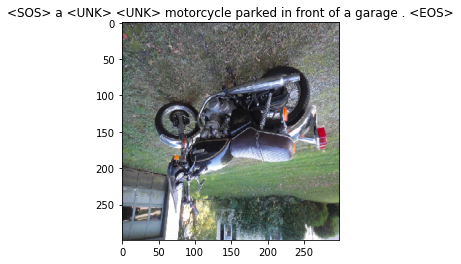

Predicted


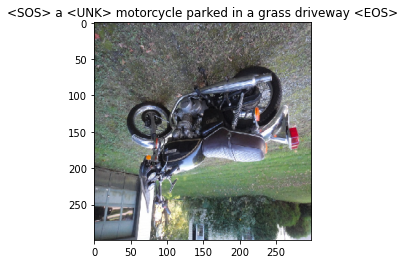

Original


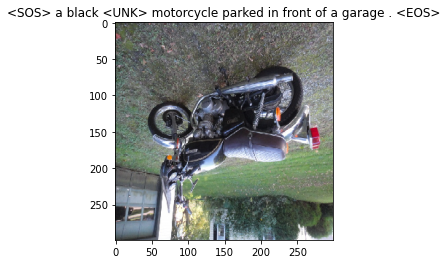

In [28]:
embed_size = 1024
hidden_size = 512
vocab_size = len(dataset.vocab)
model = CNNtoRNN(2048, embed_size, hidden_size, vocab_size, train_CNN=False)
overfit(model, 600)
del model

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
for imgs,caps in data_loader:
    print(f"\nimg shape:{imgs.shape}")
    print(f"\ncap shape:{caps.shape}")
    print(f"\nFirst caption:{caps[0]}")
    print(f"\nFirst embed:{caps[0][0]}")
    break

In [ ]:
!conda install -c conda-forge -y ipywidgets 

In [ ]:
!source /home/yandex/DLW2021/davidhay/anaconda3/bin/activate
!conda info

In [ ]:
!conda activate /home/yandex/DLW2021/davidhay/anaconda3/envs/new-env
!conda info --envs




In [16]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated()


0

In [3]:
import gc
import torch
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
gc.collect()
memReport()

/home/yandex/DLW2021/davidhay/anaconda3/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:151: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


In [2]:
!nvidia-smi
!kill -9 40485

Sat Aug 28 11:43:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:3D:00.0 Off |                  N/A |
| 33%   55C    P2   119W / 250W |   5061MiB / 12196MiB |     70%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:3E:00.0 Off |                  N/A |
| 23%   

In [ ]:
data_loader.dataset